In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from numpy import genfromtxt
from scipy.spatial import distance
from torch_geometric.data import Data
import os
import glob
from pylab import *
from matplotlib.pyplot import imread
import networkx as nx
import h5py
import csv
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

import os.path as osp
import torch
from torch_geometric.data import Dataset, download_url

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


In [1]:
from dataset import HypersimDataset
import json
import os


if os.path.isfile(r"./graphs.json"):
    with open("graphs.json", 'r') as f:
        graphs = json.load(f)
try_dataset = HypersimDataset(root='./', classes=[1, 2, 8, 11, 12, 18], presaved_graphs=graphs)
len(try_dataset)

Error: 

In [2]:
try_dataset.processed_dir

'.\\processed'

In [2]:
# LOAD DATASET

from dataset import HypersimDataset
import json
import os


# load graphs of interest if already saved
if os.path.isfile(r"./graphs.json"):
    with open("graphs.json", 'r') as f:
        graphs = json.load(f)
    dataset = HypersimDataset(root=r'C:\Users\amali\Documents\ds_research\ml-hypersim', classes=[1, 2, 8, 11, 12, 18], presaved_graphs=graphs)

else: 
    dataset = HypersimDataset(root=r'C:\Users\amali\Documents\ds_research\ml-hypersim', classes=[1, 2, 8, 11, 12, 18])
    graphs = dataset.graphs
    with open("graphs.json", 'w') as f:
        json.dump(graphs, f, indent=2)
        
raw_dataset = HypersimDataset(root=r'C:\Users\amali\Documents\ds_research\ml-hypersim', ignore_rare=False)

# print(f'Working dataset contains {len(dataset.graphs)}/{len(dataset)} available graphs.')

In [24]:
# from torch_geometric.loader import DataLoader
# import random

# indices = list(range(len(dataset.graphs)))
# selected_indices = random.sample(indices, 2000)
# train_dataset = torch.utils.data.Subset(dataset, selected_indices)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=True)

# # train_dataset = dataset[:round(dataset.len()/2)]
# # test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [3]:
# SAMPLE FROM DATASET FOR OVERFITTING EXPERIMENT

import random
import numpy as np
from torch_geometric.loader import DataLoader

print('fetch class labels')

file = './class_indices_dict.json'
if  os.path.isfile(file):
    with open(file, 'r') as f:
        class_indices_dict = json.load(f)
else:
    class_labels = np.array(np.arange(6), dtype=int)
    class_indices_dict = {int(label): [] for label in class_labels}
    for idx in tqdm(range(len(dataset.graphs))):
        label = dataset[idx].y.item()
        class_indices_dict[int(label)].append(idx)

selected_indices = []

num_samples_per_class = 10
for class_indices in class_indices_dict.values():
    selected_class_indices = random.sample(class_indices, num_samples_per_class)
    selected_indices.extend(selected_class_indices)

train_dataset = torch.utils.data.Subset(dataset, selected_indices)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)


fetch class labels


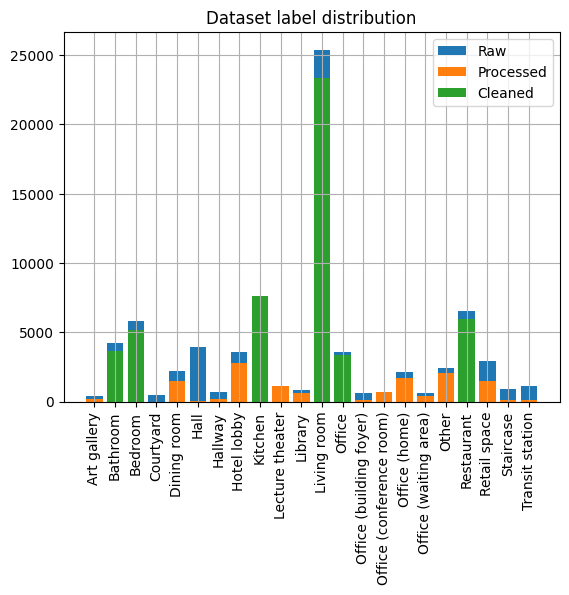

In [7]:
# RAW DATASET - AS WAS DOWNLOADED IN IMAGE FORM
scene_names = raw_dataset.scene_metadata_w_cams[:,2]
labels_raw, counts_raw = np.unique(scene_names, return_counts=True)
ticks_raw = range(len(counts_raw))
plt.bar(ticks_raw ,counts_raw*100, align='center', label='Raw')

# PROCESSED DATASET - REMOVED GRAPHS WITH 0 EDGE INDEX
# y_labels = []
# for idx in tqdm(range(len(raw_dataset))):
#     y_labels.append(dataset[idx].y.item())
# y_labels = np.array(y_labels)
# np.save('./y_labels_processed_data.npy', y_labels)
y_labels = np.load('./y_labels_processed_data.npy')

labels, counts = np.unique(y_labels, return_counts=True)
counts = np.concatenate((counts[:3], np.array([0]), counts[3:]))
labels = np.concatenate((labels[:3], np.array([3]), labels[3:]))
ticks = range(len(counts+1))
plt.bar(ticks,counts, align='center', label='Processed (remove 0-connectivity)')

# PROCESSED AND CLEANED DATASET - REMOVED RARE CLASSES (STILL NEED TO REMOVE THOSE W LABEL 'WEIRD')
counts_cleaned = np.zeros_like(counts)
for i in np.array([1, 2, 8, 11, 12, 18]):
    counts_cleaned[i] = counts[i]
plt.bar(ticks, counts_cleaned, align='center', label='Cleaned (remove rare classes)')

_ = plt.xticks(ticks, np.unique(scene_names), rotation='vertical')
plt.grid()
_ = plt.title("Dataset label distribution")
plt.legend()
plt.savefig('dataset_labels.png')

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 6) # 6 possible output labels

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        # print(edge_index[0])
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        embedding = x

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x, embedding

In [5]:
print(model)
print(sum(p.numel() for p in model.parameters()))

NameError: name 'model' is not defined

In [7]:
def train():
    
    model.train()

    # for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):  # Iterate in batches over the training dataset.
    for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out,_ = model(data.x.float(), data.edge_index.type(torch.long), data.batch.type(torch.long))  # Perform a single forward pass.
        loss = criterion(out, data.y.type(torch.long))  # Compute the loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        

def test(loader):
    model.eval()
    correct = 0
    embeddings = []

    predicted_labels = []
    true_labels = []
    
    # for data in tqdm(loader):  # Iterate in batches over the training/test dataset.
    for data in loader:  # Iterate in batches over the training/test dataset
        out, _ = model(data.x.float(), data.edge_index.type(torch.long), data.batch.type(torch.long))  
        # embeddings.append(embedding)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    
        predicted_labels.extend(pred.tolist())
        true_labels.extend(data.y.tolist())
    
    return correct / len(loader.dataset), predicted_labels, true_labels  # Derive ratio of correct predictions.

In [8]:
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import wandb
import networkx as nx
from torch_geometric.utils.convert import to_networkx


wandb.init(project="ml-hypersim", name="3conv_16h_60x")
config = {
    "hidden_channels": 16,
    "lr": 0.01,
    "num_hidden_layers": 3,
    "num_input_data_points": len(train_dataset),
    "optimizer": "adam",
    "loss": "cross_entropy"
}
wandb.config.update(config)

model = GCN(hidden_channels=config["hidden_channels"]) # TODO try with 2 data sample each
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
criterion = torch.nn.CrossEntropyLoss()


for epoch in range(0, 2):
    train()
    train_acc, _, _= test(train_loader)
    # test_acc, _ = test(test_loader)
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
    wandb.log({"Train Accuracy": train_acc})
    # wandb.log({"Model Weights": wandb.Histogram(model.state_dict())})
    # wandb.log({"Model Parameters": wandb.Histogram(torch.cat([p.flatten() for p in model.parameters()]))})
    wandb.watch(model, log="all")
    # if epoch == 0:  # Log input data only once
    #     for i in selected_indices:
    #         vis = to_networkx(dataset[i])
    #         plt.figure(1,figsize=(4,4))
    #         nx.draw(vis, cmap=plt.get_cmap('Set3'), node_size=50, linewidths=6)
    #         wandb.log({"Graph Visualization": wandb.Image(plt)})
    #         plt.close()


_, predicted_labels, true_labels = test(train_loader)
confusion_mat = confusion_matrix(true_labels, predicted_labels)
label_names=np.array(['bathroom', 'bedroom', 'kitchen', 'living room', 'office', 'restaurant'])
wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=predicted_labels, class_names=label_names)})

print("done")
wandb.finish()

# plt.figure(figsize=(10, 8))

# sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=label_names, yticklabels=label_names)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

Epoch: 000, Train Acc: 0.1667
Epoch: 001, Train Acc: 0.1667
done


Train Accuracy,▁▁
Train Accuracy,0.16667


In [12]:
_, predicted_labels, true_labels = test(train_loader)
print(predicted_labels)
print(true_labels)

confusion_mat = confusion_matrix(true_labels, predicted_labels)
classes = range(6)

plt.figure(figsize=(10, 8))
label_names=np.array(['bathroom', 'bedroom', 'kitchen', 'living room', 'office', 'restaurant'])
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

AttributeError: 'NoneType' object has no attribute '_log'

In [22]:
train_acc, predicted_labels, true_labels = test(train_loader)

In [56]:
labels = []
for data in tqdm(train_loader):
    label = data.y.numpy()
    labels.append(label)
labels_np = np.array(labels).flatten()

num_classes = len(np.unique(labels))
color_map = plt.get_cmap('tab10', num_classes)

100%|██████████| 202/202 [00:06<00:00, 29.01it/s]


In [ ]:
from sklearn.manifold import TSNE
embs = torch.cat(embeddings, dim=0)
# xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
tsne_emb = TSNE().fit_transform(embs.detach().numpy())

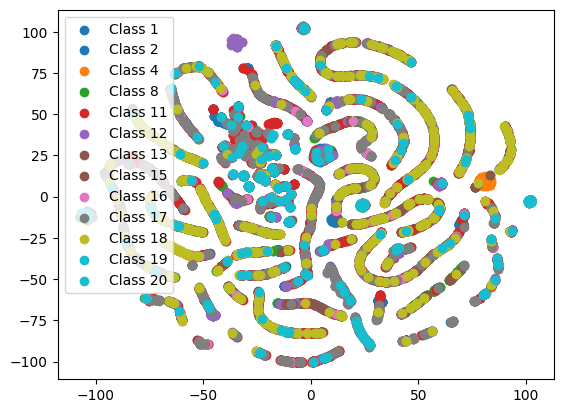

In [106]:
for j, i in enumerate(np.unique(labels)):
    class_indices = np.where(labels_np == i)[0]
    plt.scatter(tsne_emb[class_indices, 0], tsne_emb[class_indices, 1], color=color_map(j), label=f'Class {i}')
plt.legend()

In [ ]:
j = 0
for i in range(0, 49737):
    x = torch.load(r'C:\Users\amali\Documents\ds_research\ml-hypersim\processed\data_{}.pt'.format(i))
    if len(x.edge_index) == 0:
        # print(i, x, x.y)
        j += 1
        if j == 64:
            print(i-64)
    else:
        j = 0

In [30]:
from configparser import ConfigParser
config = ConfigParser()
config.read('./config.yaml')
config['dataset']['classes']

'1, 2, 8, 11,12,18'

In [31]:
int(config['model']['hidden_channels'])

16

In [32]:
[int(x) for x in config['dataset']['classes'].split(',')]

[1, 2, 8, 11, 12, 18]